### Loading Packages 

In [333]:
# Warning Libraries :
import warnings
warnings.filterwarnings("ignore")

# Scientific and Data Manipulation Libraries :
import pandas as pd
import numpy as np
import math
import gc
import os
import joblib 
pd.set_option('display.max_rows', 160)
from sklearn.preprocessing            import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MaxAbsScaler,LabelEncoder

In [334]:
# Define the variables you want to delete
variables_to_delete = ['X', 'y', 'X_train', 'X_test', 'y_train', 'y_test',
                       'X_train_scaled', 'X_test_scaled', 'test_scaled',
                       'trainset', 'testset']

# Loop through the variables and attempt deletion
for var_name in variables_to_delete:
    if globals().get(var_name) is not None:
        del globals()[var_name]

### Data Load 

In [335]:
path = r'C:\\Temporary D Drive\\D Drive\\ML Projects\\Deep Learning Project\\HR Analytics My Submissions\\'

In [336]:
# path = '/kaggle/input/analyticsvidhya-human-resource-analytics/'
test = pd.read_csv(path + 'test.csv')
train = pd.read_csv(path + 'train.csv')

### Data Pre Processing 

In [337]:
# from Preprocess import DataPreprocessor
# from Preprocess import FeatureEngineering as FE

In [338]:
def calc_smooth_mean(X_train1, X_test1,X_train1_1, groupby_col, target_col, m):
    mean = X_train1_1[target_col].mean()
    agg = X_train1_1.groupby(groupby_col)[target_col].agg(['count', 'mean'])
    
    counts = agg['count']
    means = agg['mean']
    
    smooth = (counts * means + m * mean) / (counts + m)
    
    return X_train1[groupby_col].map(smooth), X_test1[groupby_col].map(smooth)

In [339]:
def get_dummies(df,col):
    dummies = pd.get_dummies(df[str(col)], drop_first = True)
    fin = pd.concat([df, dummies], axis = 1).drop([str(col)], axis = 1)
    
    return fin

In [340]:
def pre_processing(data):
    data.drop_duplicates(keep="first", inplace=True) 
    print("Duplicated removed",data.shape)

    data.set_index('employee_id', inplace=True)
    print("EID set to Index",data.index)

    data["previous_year_rating"] = data["previous_year_rating"].fillna(0)
    print("Previous Year Rating set = 0",data.shape)

    return data

In [341]:
def missing_imputation_train(dataset):
    global pct_train
    freq_train = dataset.groupby(["department", "gender", "recruitment_channel"])["education"].value_counts().unstack()
    pct_train = freq_train.divide(freq_train.sum(axis=1), axis=0)

    pct_train["new_val"] = ""
    for i in range(pct_train.shape[0]):
        if (pct_train.values[i][2] >= 0.30) and (pct_train.values[i][0] < 0.69):
            pct_train["new_val"][i] = "Master's & above"
        elif (pct_train.values[i][0] >= 0.70) and (pct_train.values[i][2] <= 0.28):
            pct_train["new_val"][i] = "Bachelor's"
        elif pct_train.values[i][0] >= 0.70:
            pct_train["new_val"][i] = "Bachelor's"
        else:
             pct_train["new_val"][i] = "Below Secondary"
    return pct_train

In [342]:
def impute_missing_education_test(test_data, pct_train):
    test_data["education_imputed"] = ""
    for i in range(pct_train.shape[0]):
        if (pct_train.values[i][2] >= 0.30) and (pct_train.values[i][0] < 0.69):
            test_data.loc[(test_data.education.isnull()) & 
                          (test_data.department == pct_train.index[i][0]) & 
                          (test_data.gender == pct_train.index[i][1]) & 
                          (test_data.recruitment_channel == pct_train.index[i][2]), "education_imputed"] = "Master's & above"
        elif (pct_train.values[i][0] >= 0.70) and (pct_train.values[i][2] <= 0.28):
            test_data.loc[(test_data.education.isnull()) & 
                          (test_data.department == pct_train.index[i][0]) & 
                          (test_data.gender == pct_train.index[i][1]) & 
                          (test_data.recruitment_channel == pct_train.index[i][2]), "education_imputed"] = "Bachelor's"
        elif pct_train.values[i][0] >= 0.70:
            test_data.loc[(test_data.education.isnull()) & 
                          (test_data.department == pct_train.index[i][0]) & 
                          (test_data.gender == pct_train.index[i][1]) & 
                          (test_data.recruitment_channel == pct_train.index[i][2]), "education_imputed"] = "Bachelor's"
        else:
            test_data.loc[(test_data.education.isnull()) & 
                          (test_data.department == pct_train.index[i][0]) & 
                          (test_data.gender == pct_train.index[i][1]) & 
                          (test_data.recruitment_channel == pct_train.index[i][2]), "education_imputed"] = "Below Secondary"
    test_data["education"].fillna(test_data["education_imputed"], inplace=True)
    test_data.drop(columns=["education_imputed"], inplace=True)
    return test_data

In [343]:
def impute_missing_education_train(df, pct_train):

    for i in range(pct_train.shape[0]):

            df.loc[(df.education.isnull()) & (df.department == pct_train.index[i][0]) & \
                         (df.gender == pct_train.index[i][1])\
                         & (df.recruitment_channel == pct_train.index[i][2]), "education"] = pct_train.new_val.values[i]
    return df

In [344]:
def scaling(X_train, X_test):

    scaler = RobustScaler().fit(X_train)

    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index = X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns,index = X_test.index)
    return X_train_scaled, X_test_scaled

### Feature Engineering 

In [345]:
def rd(X_train1):
    rd1 = X_train1.groupby(["region", "department"]).size()
    rd2 = X_train1.groupby(["region", "department"])["age"].mean()
    rd3 = X_train1.groupby(["region", "department"])["avg_training_score"].mean()
    rd4 = X_train1.groupby(["region", "department"])["total_success"].mean()
    rd5 = X_train1.groupby(["region", "department"])["previous_year_rating"].mean()
    rd6 = X_train1.groupby(["region", "department"])["length_of_service"].mean()
    rd7 = X_train1.groupby(["region", "department"])["is_firstyear"].sum()
    
    return rd1,rd2,rd3,rd4,rd5,rd6,rd7

In [346]:
def d(X_train1):
    d1 = X_train1.groupby("department").size()
    d2 = X_train1.groupby("department")["age"].mean()
    d3 = X_train1.groupby("department")["avg_training_score"].mean()
    d4 = X_train1.groupby("department")["total_success"].mean()
    d5 = X_train1.groupby("department")["previous_year_rating"].mean()
    d6 = X_train1.groupby("department")["length_of_service"].mean()
    d7 = X_train1.groupby("department")["is_firstyear"].sum()
    
    return d1,d2,d3,d4,d5,d6,d7

In [347]:
def feature_engineering(X_train1,X_test1):
    
    #Train
    X_train1["is_firstyear"] = X_train1["length_of_service"].apply(lambda x: 1 if x==1 else 0)
    X_train1["starting_age"] = X_train1["age"] - X_train1["length_of_service"]
    X_train1["total_success"] = X_train1["avg_training_score"] + X_train1["KPIs_met >80%"]*100 + X_train1["awards_won?"]* 100 + X_train1["previous_year_rating"]*20
    
    # Test
    X_test1["is_firstyear"] = X_test1["length_of_service"].apply(lambda x: 1 if x==1 else 0)
    X_test1["starting_age"] = X_test1["age"] - X_test1["length_of_service"]
    X_test1["total_success"] = X_test1["avg_training_score"] + X_test1["KPIs_met >80%"]*100 + X_test1["awards_won?"]* 100 + X_test1["previous_year_rating"]*20
    
    rd1,rd2,rd3,rd4,rd5,rd6,rd7 = rd(X_train1)


    for i in range(rd1.shape[0]):
        region = rd1.index[i][0]
        department = rd1.index[i][1]

        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "employee_per_department&region"] =          rd1[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "avg_age_for_department&region"] =           rd2[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "avg_score_for_department&region"] =         rd3[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "avg_succes_department&region"] =            rd4[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "avg_prev_year_rating_department&region"] =  rd5[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "avg_len_of_service_department&region"] =    rd6[i]
        X_train1.loc[(X_train1.region == region) & (X_train1.department == department), "total_rookie_for_department&region"] =      rd7[i]  
        
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "employee_per_department&region"] =          rd1[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "avg_age_for_department&region"] =           rd2[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "avg_score_for_department&region"] =         rd3[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "avg_succes_department&region"] =            rd4[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "avg_prev_year_rating_department&region"] =  rd5[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "avg_len_of_service_department&region"] =    rd6[i]
        X_test1.loc[(X_test1.region == region)   & (X_test1.department == department),  "total_rookie_for_department&region"] =      rd7[i]    
    
    X_train1["is_young_in_dep_reg"] = np.where((X_train1.age <= X_train1["avg_age_for_department&region"]), 0, 1)
    X_train1["better_score_in_dep_reg"] = np.where((X_train1["avg_score_for_department&region"] <= X_train1["avg_training_score"]), 1, 0)
    X_train1["better_success_in_dep_reg"] = np.where((X_train1["avg_succes_department&region"] <= X_train1["total_success"]), 1, 0)
    X_train1["better_prev_year_rating_in_dep_reg"] = np.where((X_train1["avg_prev_year_rating_department&region"] <= X_train1["previous_year_rating"]), 1, 0)
    X_train1["longer_len_of_service_rating_in_dep_reg"] = np.where((X_train1["avg_len_of_service_department&region"] <= X_train1["length_of_service"]), 1, 0)
    
    X_test1["is_young_in_dep_reg"] = np.where((X_test1.age <= X_test1["avg_age_for_department&region"]), 0, 1)
    X_test1["better_score_in_dep_reg"] = np.where((X_test1["avg_score_for_department&region"] <= X_test1["avg_training_score"]), 1, 0)
    X_test1["better_success_in_dep_reg"] = np.where((X_test1["avg_succes_department&region"] <= X_test1["total_success"]), 1, 0)
    X_test1["better_prev_year_rating_in_dep_reg"] = np.where((X_test1["avg_prev_year_rating_department&region"] <= X_test1["previous_year_rating"]), 1, 0)
    X_test1["longer_len_of_service_rating_in_dep_reg"] = np.where((X_test1["avg_len_of_service_department&region"] <= X_test1["length_of_service"]), 1, 0)
    
    d1,d2,d3,d4,d5,d6,d7 = d(X_train1)
    
    for i in range(d1.shape[0]):
        department = d1.index[i]

        X_train1.loc[(X_train1.department == department), "employee_per_department"] = d1[i]
        X_train1.loc[(X_train1.department == department), "avg_age_for_department"] = d2[i]
        X_train1.loc[(X_train1.department == department), "avg_score_for_department"] = d3[i]
        X_train1.loc[(X_train1.department == department), "avg_succes_department"] = d4[i]
        X_train1.loc[(X_train1.department == department), "avg_prev_year_rating_department"] = d5[i]
        X_train1.loc[(X_train1.department == department), "avg_len_of_service_department"] = d6[i]
        X_train1.loc[(X_train1.department == department), "total_rookie_for_department"] = d7[i] 
        
        X_test1.loc[(X_test1.department == department), "employee_per_department"] = d1[i]
        X_test1.loc[(X_test1.department == department), "avg_age_for_department"] = d2[i]
        X_test1.loc[(X_test1.department == department), "avg_score_for_department"] = d3[i]
        X_test1.loc[(X_test1.department == department), "avg_succes_department"] = d4[i]
        X_test1.loc[(X_test1.department == department), "avg_prev_year_rating_department"] = d5[i]
        X_test1.loc[(X_test1.department == department), "avg_len_of_service_department"] = d6[i]
        X_test1.loc[(X_test1.department == department), "total_rookie_for_department"] = d7[i] 
        
    X_train1["is_young_in_dep"] = np.where((X_train1.age <= X_train1["avg_age_for_department"]), 0, 1)
    X_train1["better_score_in_dep"] = np.where((X_train1["avg_score_for_department"] <= X_train1["avg_training_score"]), 1, 0)
    X_train1["better_success_in_dep"] = np.where((X_train1["avg_succes_department"] <= X_train1["total_success"]), 1, 0)
    X_train1["better_prev_year_rating_in_dep"] = np.where((X_train1["avg_prev_year_rating_department"] <= X_train1["previous_year_rating"]), 1, 0)
    X_train1["longer_len_of_service_rating_in_dep"] = np.where((X_train1["avg_len_of_service_department"] <= X_train1["length_of_service"]), 1, 0)

    X_test1["is_young_in_dep"] = np.where((X_test1.age <= X_test1["avg_age_for_department"]), 0, 1)
    X_test1["better_score_in_dep"] = np.where((X_test1["avg_score_for_department"] <= X_test1["avg_training_score"]), 1, 0)
    X_test1["better_success_in_dep"] = np.where((X_test1["avg_succes_department"] <= X_test1["total_success"]), 1, 0)
    X_test1["better_prev_year_rating_in_dep"] = np.where((X_test1["avg_prev_year_rating_department"] <= X_test1["previous_year_rating"]), 1, 0)
    X_test1["longer_len_of_service_rating_in_dep"] = np.where((X_test1["avg_len_of_service_department"] <= X_test1["length_of_service"]), 1, 0)
    
    X_train1["education"] = X_train1["education"].map({"Below Secondary": 1, "Bachelor's": 2, "Master's & above":3})
    X_test1["education"]  =  X_test1["education"].map({"Below Secondary": 1, "Bachelor's": 2, "Master's & above":3})
    
    X_train1["total_training_score"] = X_train1["no_of_trainings"] * X_train1["avg_training_score"]
    X_test1["total_training_score"] = X_test1["no_of_trainings"] * X_test1["avg_training_score"]
    
    return X_train1, X_test1

    
    

In [348]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [349]:
# dp = DataPreprocessor()
pre_processing(train)
train.info()# Step 1 for submission test set

Duplicated removed (54808, 14)
EID set to Index Index([65438, 65141,  7513,  2542, 48945, 58896, 20379, 16290, 73202, 28911,
       ...
       40257, 68093, 39227, 12431,  6915,  3030, 74592, 13918, 13614, 51526],
      dtype='int64', name='employee_id', length=54808)
Previous Year Rating set = 0 (54808, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   region                54808 non-null  object 
 2   education             52399 non-null  object 
 3   gender                54808 non-null  object 
 4   recruitment_channel   54808 non-null  object 
 5   no_of_trainings       54808 non-null  int64  
 6   age                   54808 non-null  int64  
 7   previous_year_rating  54808 non-null  float64
 8   length_of_service     54808 non-null  int64  
 9   KPIs_met >80%   

In [350]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
models = []
models.append(("LogReg", LogisticRegression(solver="liblinear", random_state=0)))

In [351]:
target = train.is_promoted
train.drop('is_promoted',axis=1 ,inplace = True)

In [356]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# smote = SMOTE(random_state=0)

# Initialize dataframe to store predicted probabilities

all_predicted_probs = pd.DataFrame({'EID': train.index, "True Label": target})
# Initialize an empty DataFrame to store predicted probabilities for all models

# Evaluate each model using cross-validation
for name, model in models:
    print(name," Started")
#     model_params = []
    # Initialize an empty DataFrame to store predicted probabilities for the current model
    model_predicted_probs = pd.DataFrame(columns=['EID', str(name) + 'Prob'])
    i = 0
    # Perform k-fold cross-validation 
    for train_index, test_index in kfold.split(train, target):
        X_train1, X_test1 = train.iloc[train_index], train.iloc[test_index]
        y_train1, y_test1 = target.iloc[train_index], target.iloc[test_index]
        
        # Impute Missing values in train
        pct_train = missing_imputation_train(X_train1) # Import class
        impute_missing_education_train(X_train1, pct_train) # Function is defined above
        
        # Impute Missing values in test
        X_test1 = impute_missing_education_test(X_test1, pct_train) # Import class
        
        # Feature Engineering : Import class
        X_train1, X_test1 = feature_engineering(X_train1, X_test1)
        
        

        
        
        # Smoothening : Function defined above
        
        #https://maxhalford.github.io/blog/target-encoding/
        X_train1_1 = X_train1.copy()
        X_train1_1['is_promoted'] = y_train1
        
        
        
        X_train1["region"], X_test1["region"] = calc_smooth_mean(X_train1, X_test1,X_train1_1, "region", "is_promoted", 300)
        X_train1["department"], X_test1["department"] = calc_smooth_mean(X_train1, X_test1,X_train1_1, "department", "is_promoted", 300)
        X_train1["recruitment_channel"], X_test1["recruitment_channel"] = calc_smooth_mean(X_train1, X_test1,X_train1_1, "recruitment_channel", "is_promoted", 300)

        
        
        
        # Dummy variable
        X_train1 = get_dummies(X_train1, "gender")
        X_test1 = get_dummies(X_test1, "gender")
        
        # Scaling
        X_train1, X_test1 = scaling(X_train1, X_test1)
        
        
        
        for column in X_train1.columns:
            # Check if the column contains any missing values
            if X_train1[column].isnull().any():
                # If missing values are found, fill them with zeros
                X_train1[column].fillna(0, inplace=True)

        # Iterate over each column in the feature engineering DataFrame of the test set
        for column in X_test1.columns:
            # Check if the column contains any missing values
            if X_test1[column].isnull().any():
                # If missing values are found, fill them with zeros
                X_test1[column].fillna(0, inplace=True)
        
        
        # Train the model
        model.fit(X_train1, y_train1)
#         display(X_train1.head(3))
#         display(X_test1.head(3))
    
        # Predict probabilities for the current fold's test set
        probabilities = model.predict_proba(X_test1)[:, 1]

        # Create a DataFrame to store the predicted probabilities for the current fold
        fold_predicted_probs = pd.DataFrame({'EID': X_test1.index, str(name) + 'Prob': probabilities})
        
        # Concatenate the fold predicted probabilities to the model's DataFrame
        model_predicted_probs = pd.concat([model_predicted_probs, fold_predicted_probs], ignore_index=True)
        
        if name in ["LogReg"]:
            
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(name, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')

 
        elif name in ['RF','KNN','GNB','AdB','CB']:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        elif name in ["DT","LGBM"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        elif name in ["XGB"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
                        
        elif name in ["GDB"]:
            joblib.dump(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
            print(model, str(name) + f'_B1_SMOTE_2604_fold_{i+1}')
        
        i+=1
        
    
    # Merge the predicted probabilities of the current model with the overall DataFrame
    all_predicted_probs = pd.merge(all_predicted_probs, model_predicted_probs, on='EID', how='outer')


    print(name," Done")

LogReg  Started


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.780362,0.761071,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.669907,0.000000,0.817362,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.998873,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.818808,1.112315,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.780362,-0.537169,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.669907,0.000000,0.817362,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
20379,0.000000,-0.293402,0.0,0.0,0.0,-0.2,0.0,0.00,0.0,0.0,...,0.818808,1.112315,0.000000,0.0,0.0,0.0,-1.0,0.0,-0.161290,-1.0
2370,0.698415,-0.402839,0.0,0.0,0.0,0.0,0.5,-0.25,0.0,0.0,...,-0.449135,-0.075129,-0.031567,0.0,0.0,0.0,0.0,0.0,0.483871,0.0
24104,-0.296567,0.000000,0.0,1.0,0.0,-1.3,0.5,-0.75,1.0,0.0,...,0.037449,-2.627330,-0.331454,0.0,0.0,1.0,0.0,0.0,-0.129032,0.0


LogReg LogReg_B1_SMOTE_2604_fold_1


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.714982,0.681100,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.645764,0.0,0.824,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
7513,-0.714982,-0.340796,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.645764,0.0,0.824,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0
2542,-0.714982,0.806529,0.0,0.0,1.0,0.6,-1.0,1.25,0.0,0.0,...,-0.645764,0.0,0.824,1.0,0.0,0.0,-1.0,1.0,1.161290,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65141,0.000000,0.831379,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.837782,1.202090,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
38401,0.743172,-0.721788,1.0,0.0,1.0,0.6,0.0,2.75,0.0,0.0,...,-0.418835,-0.028532,-0.026286,1.0,1.0,0.0,0.0,1.0,3.096774,0.0
52057,-0.350691,0.831379,1.0,1.0,1.0,0.6,1.0,0.50,0.0,0.0,...,0.037850,-2.652202,-0.324571,1.0,0.0,0.0,0.0,1.0,1.741935,0.0


LogReg LogReg_B1_SMOTE_2604_fold_2


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.692576,0.861615,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.640705,0.000000,0.79786,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.991924,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.792686,1.164585,0.00000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
2542,-0.692576,0.842364,0.0,0.0,1.0,0.6,-1.0,1.25,0.0,0.0,...,-0.640705,0.000000,0.79786,1.0,0.0,0.0,-1.0,1.0,1.161290,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
7513,-0.692576,-0.400014,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.640705,0.000000,0.797860,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0
77040,-0.718046,0.000000,1.0,1.0,0.0,0.4,0.0,0.50,0.0,0.0,...,0.403951,-3.357729,-0.619501,1.0,0.0,0.0,-1.0,1.0,0.645161,0.0
9403,-0.692576,-0.593196,0.0,0.0,0.0,0.1,-1.0,-0.25,0.0,0.0,...,-0.640705,0.000000,0.797860,0.0,1.0,0.0,-1.0,0.0,-0.419355,0.0


LogReg LogReg_B1_SMOTE_2604_fold_3


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.892825,0.723668,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.675627,0.000000,0.806381,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.900193,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.797371,1.182374,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.892825,-0.276332,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.675627,0.000000,0.806381,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
48945,0.700462,-0.307630,0.0,0.0,0.0,1.2,0.0,-0.75,0.0,0.0,...,-0.483946,0.068501,-0.023102,1.0,0.0,0.0,0.0,0.0,0.290323,0.0
49017,-0.892825,0.723668,0.0,1.0,0.0,0.2,1.0,-0.50,1.0,0.0,...,-0.675627,0.000000,0.806381,1.0,0.0,1.0,0.0,0.0,-0.451613,-1.0
60051,-0.892825,1.496150,0.0,1.0,0.0,1.6,1.0,0.00,1.0,0.0,...,-0.675627,0.000000,0.806381,1.0,0.0,1.0,0.0,0.0,-0.483871,0.0


LogReg LogReg_B1_SMOTE_2604_fold_4


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.755813,0.761167,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.649805,0.000000,0.8125,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.968521,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.816551,1.213322,0.0000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.755813,-0.357265,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.649805,0.000000,0.8125,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
37749,0.244187,-0.458398,0.0,0.0,0.0,-0.2,1.0,-0.25,1.0,0.0,...,0.000000,1.000000,-0.187500,0.0,0.0,1.0,0.0,0.0,0.129032,0.0
64062,0.724453,0.837079,0.0,1.0,0.0,0.0,0.5,-0.25,1.0,0.0,...,-0.448172,0.029706,-0.056818,0.0,0.0,1.0,0.0,0.0,0.354839,0.0
3113,-0.755813,-0.787174,0.0,1.0,0.0,-0.8,0.0,-0.50,0.0,0.0,...,-0.649805,0.000000,0.812500,0.0,1.0,0.0,0.0,0.0,-0.354839,0.0


LogReg LogReg_B1_SMOTE_2604_fold_5


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.725316,0.734629,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.630578,0.000000,0.831002,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,1.138134,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.836825,1.258687,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.725316,-0.337989,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.630578,0.000000,0.831002,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
17423,-0.725316,0.000000,0.0,0.0,2.0,-0.9,-0.5,-0.75,0.0,0.0,...,-0.630578,0.000000,0.831002,0.0,0.0,0.0,-1.0,0.0,2.580645,0.0
73161,0.000000,1.138134,0.0,0.0,0.0,0.6,0.0,0.00,1.0,0.0,...,0.836825,1.258687,0.000000,1.0,1.0,1.0,-1.0,0.0,-0.064516,0.0
77981,-0.469603,1.138134,0.0,0.0,0.0,-0.6,-1.5,-1.00,1.0,1.0,...,0.039879,-2.731004,-0.343823,0.0,0.0,1.0,-1.0,0.0,-0.193548,0.0


LogReg LogReg_B1_SMOTE_2604_fold_6


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65141,0.000000,1.094003,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.816863,1.130872,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.687479,-0.452903,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.670175,0.000000,0.788571,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0
48945,0.683724,-0.485748,0.0,0.0,0.0,1.2,0.0,-0.75,0.0,0.0,...,-0.474425,0.034437,-0.052571,1.0,0.0,0.0,0.0,0.0,0.290323,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.687479,0.766405,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.670175,0.000000,0.788571,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
2542,-0.687479,1.049312,0.0,0.0,1.0,0.6,-1.0,1.25,0.0,0.0,...,-0.670175,0.000000,0.788571,1.0,0.0,0.0,-1.0,1.0,1.161290,0.0
29934,0.683724,1.049312,1.0,1.0,0.0,-0.3,-1.5,-1.00,0.0,0.0,...,-0.474425,0.034437,-0.052571,0.0,0.0,0.0,-1.0,0.0,0.419355,0.0


LogReg LogReg_B1_SMOTE_2604_fold_7


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.855468,0.815530,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.607177,0.000000,0.814988,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,1.050889,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.837603,1.309487,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.855468,-0.479153,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.607177,0.000000,0.814988,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
12067,0.144532,-0.091518,0.0,0.0,0.0,0.2,0.0,0.50,0.0,0.0,...,0.000000,0.996110,-0.185012,0.0,1.0,0.0,-1.0,1.0,0.354839,0.0
51756,0.000000,0.000000,0.0,1.0,1.0,2.4,0.5,0.25,0.0,0.0,...,0.837603,1.309487,0.000000,1.0,0.0,0.0,0.0,0.0,1.677419,0.0
77064,-0.855468,1.050889,0.0,0.0,0.0,0.7,-0.5,-0.25,1.0,0.0,...,-0.607177,0.000000,0.814988,1.0,0.0,1.0,-1.0,0.0,-0.548387,0.0


LogReg LogReg_B1_SMOTE_2604_fold_8


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.718643,0.798340,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.645005,0.000000,0.816901,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.992076,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.837240,1.129234,0.000000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.718643,-0.390142,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.645005,0.000000,0.816901,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
58896,0.167262,0.000000,0.0,1.0,1.0,-0.2,0.0,0.50,0.0,0.0,...,0.354995,-2.169903,-0.149061,0.0,1.0,0.0,-1.0,1.0,3.419355,0.0
16290,0.000000,-0.639405,1.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,...,0.837240,1.129234,0.000000,0.0,1.0,0.0,-1.0,0.0,-0.032258,0.0
43931,0.000000,0.798340,0.0,0.0,0.0,0.4,-1.0,1.25,0.0,0.0,...,0.837240,1.129234,0.000000,1.0,0.0,0.0,-1.0,1.0,-0.129032,0.0


LogReg LogReg_B1_SMOTE_2604_fold_9


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
65438,-0.718322,0.707800,1.0,1.0,0.0,0.2,1.0,0.75,1.0,0.0,...,-0.654876,0.000000,0.80445,1.0,0.0,1.0,0.0,1.0,-0.483871,-1.0
65141,0.000000,0.989664,0.0,0.0,0.0,-0.3,1.0,-0.25,0.0,0.0,...,0.813207,1.115824,0.00000,0.0,0.0,0.0,0.0,0.0,-0.129032,0.0
7513,-0.718322,-0.389439,0.0,1.0,0.0,0.1,0.0,0.50,0.0,0.0,...,-0.654876,0.000000,0.80445,0.0,0.0,0.0,0.0,1.0,-0.451613,0.0


,department,region,education,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,...,avg_prev_year_rating_department,avg_len_of_service_department,total_rookie_for_department,is_young_in_dep,better_score_in_dep,better_success_in_dep,better_prev_year_rating_in_dep,longer_len_of_service_rating_in_dep,total_training_score,m
employee_id,,,,,,,,,,,,,,,,,,,,,
73202,0.160057,-0.444442,0.0,0.0,0.0,-0.5,0.5,0.00,0.0,0.0,...,0.345124,-2.156117,-0.151054,0.0,0.0,0.0,0.0,1.0,0.612903,0.0
28911,-0.718322,0.518194,1.0,1.0,0.0,-0.1,1.0,0.00,1.0,0.0,...,-0.654876,0.000000,0.804450,0.0,1.0,1.0,0.0,0.0,-0.322581,0.0
17436,-0.718322,-0.650576,0.0,0.0,0.0,0.1,1.0,0.75,1.0,0.0,...,-0.654876,0.000000,0.804450,0.0,0.0,1.0,0.0,1.0,-0.580645,0.0


LogReg LogReg_B1_SMOTE_2604_fold_10
LogReg  Done


,EID,True Label,LogRegProb
0,65438,0,0.255072
1,65141,0,0.046744
2,7513,0,0.013279
3,2542,0,0.013332
4,48945,0,0.000893


In [384]:
all_predicted_probs.head()

,EID,NN_Prob,True Label_x,True Label_y,LogRegProb,RFProb,KNNProb,DTProb,GNBProb,XGBProb,GDBProb,AdBProb,CBProb,LGBMProb
0,13122,2.869751e-02,0,0,0.070090,0.09,0.0,0.0,8.500882e-01,0.217875,0.109184,0.487164,0.055610,0.054613
1,30161,1.842541e-01,1,1,0.024768,0.15,0.0,1.0,9.938212e-01,0.324126,0.242136,0.493888,0.520494,0.313984
2,38901,1.526585e-06,0,0,0.015397,0.00,0.0,0.0,3.337308e-02,0.000047,0.004543,0.474434,0.000024,0.000845
3,48479,7.023672e-10,0,0,0.003633,0.00,0.0,0.0,1.469932e-39,0.000019,0.003064,0.472543,0.000005,0.000399
4,30442,9.821610e-02,1,1,0.148134,0.02,0.2,0.0,3.402583e-01,0.081851,0.114353,0.486354,0.092546,0.112521


### Base Classifiers Comparision

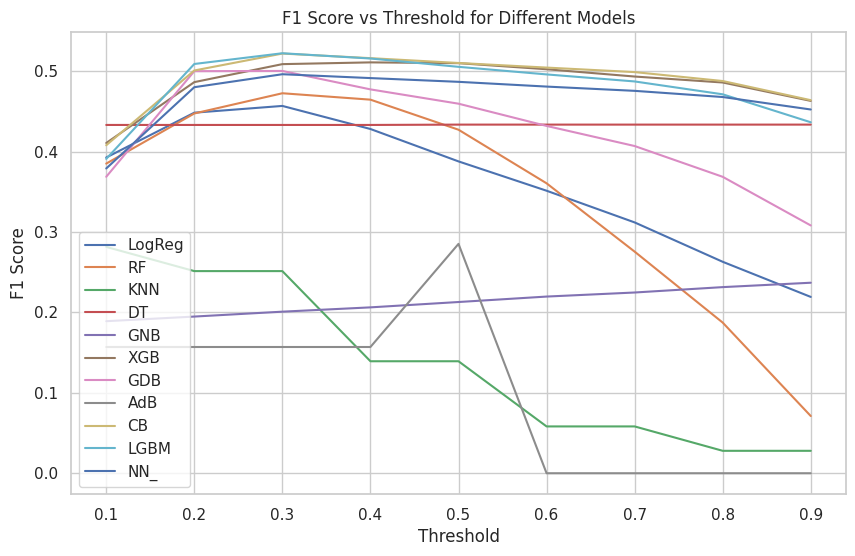

<Figure size 640x480 with 0 Axes>

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Define the list of model names
models = ['LogReg', 'RF', 'KNN', 'DT', 'GNB', 'XGB', 'GDB', 'AdB','CB', 'LGBM']

# Define a range of threshold values
thresholds = np.arange(0.1, 1.0, 0.1)  # Adjust the range as needed

# Initialize a dictionary to store F1 scores for each model
f1_scores = {model: [] for model in models}

# Calculate F1 scores for each model at different threshold values
for model in models:
    for threshold in thresholds:
        # Convert model probabilities to binary predictions using threshold
        predictions = (all_predicted_probs[model + 'Prob'] > threshold).astype(int)
        # Calculate F1 score
        f1 = f1_score(all_predicted_probs['True Label_x'], predictions)
        # Append F1 score to the dictionary
        f1_scores[model].append(f1)

# Plot F1 scores for each model
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(thresholds, f1_scores[model], label=model)

# Add labels and legend
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold for Different Models')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('f1_score_vs_threshold.png')

Thrshold = 0.3

Poor Models (F1 < 0.3): Adaboost < Gaussian NB < KNN 

Average Model (0.3 <= F1 < 0.5) : Decision Tree < Logistic Regression < RandomForest < Neural Network <Gradient Boosting
    
Best Models (F1 >= 0.5) : LGBM = CatBoost > XGBoost

In [389]:
all_predicted_probs.columns

Index(['EID', 'NN_Prob', 'True Label_x', 'True Label_y', 'LogRegProb',
       'RFProb', 'KNNProb', 'DTProb', 'GNBProb', 'XGBProb', 'GDBProb',
       'AdBProb', 'CBProb', 'LGBMProb'],
      dtype='object')

In [395]:
# Create a new DataFrame with selected columns
final_models = all_predicted_probs[['EID', 'True Label_x', 'LGBMProb', 'CBProb', 'XGBProb','GDBProb']]

# Apply threshold and convert probabilities into binary predictions
threshold = 0.3
final_models['LGBMPred'] = (final_models['LGBMProb'] >= threshold).astype(int)
final_models['CatBoostPred'] = (final_models['CBProb'] >= threshold).astype(int)
final_models['XGBoostPred'] = (final_models['XGBProb'] >= threshold).astype(int)
# final_models['NN_Pred'] = (final_models['NN_Prob'] >= threshold).astype(int)
final_models['GradientBoostPred'] = (final_models['GDBProb'] >= threshold).astype(int)

# Save the DataFrame
final_models.to_csv('final_models.csv', index=False)

final_models.head()

,EID,True Label_x,LGBMProb,CBProb,XGBProb,NN_Prob,GDBProb,LGBMPred,CatBoostPred,XGBoostPred,NN_Pred,GradientBoostPred
0,13122,0,0.054613,0.055610,0.217875,2.869751e-02,0.109184,0,0,0,0,0
1,30161,1,0.313984,0.520494,0.324126,1.842541e-01,0.242136,1,1,1,0,0
2,38901,0,0.000845,0.000024,0.000047,1.526585e-06,0.004543,0,0,0,0,0
3,48479,0,0.000399,0.000005,0.000019,7.023672e-10,0.003064,0,0,0,0,0
4,30442,1,0.112521,0.092546,0.081851,9.821610e-02,0.114353,0,0,0,0,0


In [397]:
# Define a threshold
threshold = 0.3

# Convert probabilities to binary predictions based on the threshold
true_labels = final_models['True Label_x']

pred_labels_lgbm = final_models['LGBMPred']
pred_labels_catboost = final_models['CatBoostPred']
pred_labels_xgboost = final_models['XGBoostPred']
# pred_labels_nn = final_models['NN_Pred']
pred_labels_gdb = final_models['GradientBoostPred']

prob_lgbm = final_models['LGBMProb']
prob_catboost = final_models['CBProb']
prob_xgboost = final_models['XGBProb']
# prob_nn = final_models['NN_Prob']
prob_gdb = final_models['GDBProb']


### Evaluation Metric Calculations 

In [398]:
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score, f1_score

# Accuracy
accuracy_lgbm = (true_labels == pred_labels_lgbm).mean()
accuracy_catboost = (true_labels == pred_labels_catboost).mean()
accuracy_xgboost = (true_labels == pred_labels_xgboost).mean()

# accuracy_nn = (true_labels == pred_labels_nn).mean()
accuracy_gdb = (true_labels == pred_labels_gdb).mean()


In [399]:
# Balanced Accuracy
def balanced_accuracy(true_labels, pred_labels):
    tp = sum((true_labels == 1) & (pred_labels == 1))
    tn = sum((true_labels == 0) & (pred_labels == 0))
    fp = sum((true_labels == 0) & (pred_labels == 1))
    fn = sum((true_labels == 1) & (pred_labels == 0))
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    balanced_acc = (sensitivity + specificity) / 2
    return balanced_acc

balanced_accuracy_lgbm = balanced_accuracy(true_labels, pred_labels_lgbm)
balanced_accuracy_catboost = balanced_accuracy(true_labels, pred_labels_catboost)
balanced_accuracy_xgboost = balanced_accuracy(true_labels, pred_labels_xgboost)

# balanced_accuracy_nn = balanced_accuracy(true_labels, pred_labels_nn)
balanced_accuracy_gdb = balanced_accuracy(true_labels, pred_labels_gdb)

In [400]:
from sklearn.metrics import roc_auc_score

roc_auc_lgbm = roc_auc_score(true_labels, prob_lgbm)
roc_auc_catboost = roc_auc_score(true_labels, prob_catboost)
roc_auc_xgboost = roc_auc_score(true_labels, prob_xgboost)

# roc_auc_nn = roc_auc_score(true_labels, prob_nn)
roc_auc_gdb = roc_auc_score(true_labels, prob_gdb)

In [401]:
# Average Precision
def average_precision(true_labels, probabilities):
    sorted_indices = np.argsort(probabilities)[::-1]
    true_labels_sorted = true_labels[sorted_indices]
    n_pos = sum(true_labels)
    n_neg = len(true_labels) - n_pos
    precisions = []
    tp = 0
    fp = 0
    for i in range(len(sorted_indices)):
        if true_labels_sorted[i] == 1:
            tp += 1
        else:
            fp += 1
        precision = tp / (tp + fp)
        if true_labels_sorted[i] == 1:
            precisions.append(precision)
    return np.mean(precisions)

average_precision_lgbm = average_precision(true_labels, prob_lgbm)
average_precision_catboost = average_precision(true_labels, prob_catboost)
average_precision_xgboost = average_precision(true_labels, prob_xgboost)

# average_precision_nn = average_precision(true_labels, prob_nn)
average_precision_gdb = average_precision(true_labels, prob_gdb)

In [402]:
# Precision, Recall, F1 Score
def precision_recall_f1(true_labels, pred_labels):
    tp = sum((true_labels == 1) & (pred_labels == 1))
    tn = sum((true_labels == 0) & (pred_labels == 0))
    fp = sum((true_labels == 0) & (pred_labels == 1))
    fn = sum((true_labels == 1) & (pred_labels == 0))
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision_lgbm, recall_lgbm, f1_lgbm = precision_recall_f1(true_labels, pred_labels_lgbm)
precision_catboost, recall_catboost, f1_catboost = precision_recall_f1(true_labels, pred_labels_catboost)
precision_xgboost, recall_xgboost, f1_xgboost = precision_recall_f1(true_labels, pred_labels_xgboost)

# precision_nn, recall_nn, f1_nn = precision_recall_f1(true_labels, pred_labels_nn)
precision_gdb, recall_gdb, f1_gdb = precision_recall_f1(true_labels, pred_labels_gdb)


In [403]:
# Precision Macro
def precision_macro(true_labels, pred_labels):
    num_classes = len(np.unique(true_labels))
    precisions = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fp = sum((true_labels != class_label) & (pred_labels == class_label))
        if tp + fp == 0:
            precision = 0  # Handle division by zero
        else:
            precision = tp / (tp + fp)
        precisions.append(precision)
    return np.mean(precisions)

precision_macro_lgbm = precision_macro(true_labels, pred_labels_lgbm)
precision_macro_catboost = precision_macro(true_labels, pred_labels_catboost)
precision_macro_xgboost = precision_macro(true_labels, pred_labels_xgboost)

# precision_macro_nn = precision_macro(true_labels, pred_labels_nn)
precision_macro_gdb = precision_macro(true_labels, pred_labels_gdb)


In [404]:
# Precision Micro
def precision_micro(true_labels, pred_labels):
    tp_total = sum((true_labels == pred_labels) & (true_labels == 1))
    fp_total = sum((true_labels != pred_labels) & (true_labels == 0))
    if tp_total + fp_total == 0:
        precision_micro = 0  # Handle division by zero
    else:
        precision_micro = tp_total / (tp_total + fp_total)
    return precision_micro

precision_micro_lgbm = precision_micro(true_labels, pred_labels_lgbm)
precision_micro_catboost = precision_micro(true_labels, pred_labels_catboost)
precision_micro_xgboost = precision_micro(true_labels, pred_labels_xgboost)

# precision_micro_nn = precision_micro(true_labels, pred_labels_nn)
precision_micro_gdb = precision_micro(true_labels, pred_labels_gdb)


In [405]:
def precision_samples(true_labels, pred_labels):
    tp = ((true_labels == 1) & (pred_labels == 1)).sum()
    fp = ((true_labels == 0) & (pred_labels == 1)).sum()
    if tp + fp == 0:
        return 0  # Handle division by zero
    else:
        return tp / (tp + fp)

precision_samples_lgbm = precision_samples(true_labels, pred_labels_lgbm)
precision_samples_catboost = precision_samples(true_labels, pred_labels_catboost)
precision_samples_xgboost = precision_samples(true_labels, pred_labels_xgboost)

# precision_samples_nn = precision_samples(true_labels, pred_labels_nn)
precision_samples_gdb = precision_samples(true_labels, pred_labels_gdb)



In [406]:
# Precision Weighted
def precision_weighted(true_labels, pred_labels, sample_weight):
    num_classes = len(np.unique(true_labels))
    precisions = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fp = sum((true_labels != class_label) & (pred_labels == class_label))
        if tp + fp == 0:
            precision = 0  # Handle division by zero
        else:
            precision = tp / (tp + fp)
        precisions.append(precision * sample_weight[class_label])
    return np.sum(precisions) / np.sum(sample_weight)
sample_weight = np.array([0.5,0.5])
precision_weighted_lgbm = precision_weighted(true_labels, pred_labels_lgbm, sample_weight)
precision_weighted_catboost = precision_weighted(true_labels, pred_labels_catboost, sample_weight)
precision_weighted_xgboost = precision_weighted(true_labels, pred_labels_xgboost, sample_weight)

# precision_weighted_nn = precision_weighted(true_labels, pred_labels_nn, sample_weight)
precision_weighted_gdb = precision_weighted(true_labels, pred_labels_gdb, sample_weight)


In [407]:
# Recall Macro
def recall_macro(true_labels, pred_labels):
    num_classes = len(np.unique(true_labels))
    recalls = []
    for class_label in range(num_classes):
        tp = sum((true_labels == class_label) & (pred_labels == class_label))
        fn = sum((true_labels == class_label) & (pred_labels != class_label))
        if tp + fn == 0:
            recall = 0  # Handle division by zero
        else:
            recall = tp / (tp + fn)
        recalls.append(recall)
    return np.mean(recalls)

recall_macro_lgbm = recall_macro(true_labels, pred_labels_lgbm)
recall_macro_catboost = recall_macro(true_labels, pred_labels_catboost)
recall_macro_xgboost = recall_macro(true_labels, pred_labels_xgboost)

# recall_macro_nn = recall_macro(true_labels, pred_labels_nn)
recall_macro_gdb = recall_macro(true_labels, pred_labels_gdb)

In [408]:
def recall_samples(true_labels, pred_labels):
    num_samples = len(true_labels)
    recalls = []
    for i in range(num_samples):
        if true_labels[i] == 1:
            tp = int(true_labels[i] == pred_labels[i])
            fn = int(true_labels[i] != pred_labels[i])
            recall = tp / (tp + fn) if (tp + fn) != 0 else 0
            recalls.append(recall)
    return np.mean(recalls)

# Call the function for each model
recall_samples_lgbm = recall_samples(true_labels, pred_labels_lgbm)
recall_samples_catboost = recall_samples(true_labels, pred_labels_catboost)
recall_samples_xgboost = recall_samples(true_labels, pred_labels_xgboost)

# recall_samples_nn = recall_samples(true_labels, pred_labels_nn)
recall_samples_gdb = recall_samples(true_labels, pred_labels_gdb)


In [409]:
#  Recall Micro
recall_micro_lgbm = recall_score(true_labels, pred_labels_lgbm, average='micro')
recall_micro_catboost = recall_score(true_labels, pred_labels_catboost, average='micro')
recall_micro_xgboost = recall_score(true_labels, pred_labels_xgboost, average='micro')

# recall_micro_nn = recall_score(true_labels, pred_labels_nn, average='micro')
recall_micro_gdb = recall_score(true_labels, pred_labels_gdb, average='micro')


# Recall Weighted
recall_weighted_lgbm = recall_score(true_labels, pred_labels_lgbm, average='weighted')
recall_weighted_catboost = recall_score(true_labels, pred_labels_catboost, average='weighted')
recall_weighted_xgboost = recall_score(true_labels, pred_labels_xgboost, average='weighted')

# recall_weighted_nn = recall_score(true_labels, pred_labels_nn, average='weighted')
recall_weighted_gdb = recall_score(true_labels, pred_labels_gdb, average='weighted')


In [410]:
# F1 Score Macro
f1_macro_lgbm = f1_score(true_labels, pred_labels_lgbm, average='macro')
f1_macro_catboost = f1_score(true_labels, pred_labels_catboost, average='macro')
f1_macro_xgboost = f1_score(true_labels, pred_labels_xgboost, average='macro')

# f1_macro_nn = f1_score(true_labels, pred_labels_nn, average='macro')
f1_macro_gdb = f1_score(true_labels, pred_labels_gdb, average='macro')

In [411]:
# F1 Score Micro
f1_micro_lgbm = f1_score(true_labels, pred_labels_lgbm, average='micro')
f1_micro_catboost = f1_score(true_labels, pred_labels_catboost, average='micro')
f1_micro_xgboost = f1_score(true_labels, pred_labels_xgboost, average='micro')

# f1_micro_nn = f1_score(true_labels, pred_labels_nn, average='micro')
f1_micro_gdb = f1_score(true_labels, pred_labels_gdb, average='micro')


In [412]:
# F1 Score Weighted
f1_weighted_lgbm = f1_score(true_labels, pred_labels_lgbm, average='weighted')
f1_weighted_catboost = f1_score(true_labels, pred_labels_catboost, average='weighted')
f1_weighted_xgboost = f1_score(true_labels, pred_labels_xgboost, average='weighted')

# f1_weighted_nn = f1_score(true_labels, pred_labels_nn, average='weighted')
f1_weighted_gdb = f1_score(true_labels, pred_labels_gdb, average='weighted')


In [413]:
import pandas as pd

# Create a dictionary to store the metrics
metrics_data = {
    "Model": ["LightGBM", "CatBoost", "XGBoost", "Gradient_Boost"],
    "Accuracy": [accuracy_lgbm, accuracy_catboost, accuracy_xgboost, accuracy_gdb],
    "Balanced Accuracy": [balanced_accuracy_lgbm, balanced_accuracy_catboost, balanced_accuracy_xgboost,  balanced_accuracy_gdb],
    "ROC AUC": [roc_auc_lgbm, roc_auc_catboost, roc_auc_xgboost,  roc_auc_gdb],
    "Average Precision": [average_precision_lgbm, average_precision_catboost, average_precision_xgboost,  average_precision_gdb],
    "Precision": [precision_lgbm, precision_catboost, precision_xgboost,  precision_gdb],
    "Recall": [recall_lgbm, recall_catboost, recall_xgboost, recall_gdb],
    "F1 Score": [f1_lgbm, f1_catboost, f1_xgboost,  f1_gdb],
    "Precision Macro": [precision_macro_lgbm, precision_macro_catboost, precision_macro_xgboost, precision_macro_gdb],
    "Precision Micro": [precision_micro_lgbm, precision_micro_catboost, precision_micro_xgboost, precision_micro_gdb],
    "Precision Samples": [precision_samples_lgbm, precision_samples_catboost, precision_samples_xgboost,  precision_samples_gdb],
    "Precision Weighted": [precision_weighted_lgbm, precision_weighted_catboost, precision_weighted_xgboost, precision_weighted_gdb],
    "Recall Macro": [recall_macro_lgbm, recall_macro_catboost, recall_macro_xgboost, recall_macro_gdb],
    "Recall Micro": [recall_micro_lgbm, recall_micro_catboost, recall_micro_xgboost, recall_micro_gdb],
    "Recall Samples": [recall_samples_lgbm, recall_samples_catboost, recall_samples_xgboost,  recall_samples_gdb],
    "Recall Weighted": [recall_weighted_lgbm, recall_weighted_catboost, recall_weighted_xgboost, recall_weighted_gdb],
    "F1 Score Macro": [f1_macro_lgbm, f1_macro_catboost, f1_macro_xgboost, f1_macro_gdb],
    "F1 Score Micro": [f1_micro_lgbm, f1_micro_catboost, f1_micro_xgboost, f1_micro_gdb],
    "F1 Score Weighted": [f1_weighted_lgbm, f1_weighted_catboost, f1_weighted_xgboost, f1_weighted_gdb]
}


# Create a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
display(metrics_df)


,Model,Accuracy,Balanced Accuracy,ROC AUC,Average Precision,Precision,Recall,F1 Score,Precision Macro,Precision Micro,Precision Samples,Precision Weighted,Recall Macro,Recall Micro,Recall Samples,Recall Weighted,F1 Score Macro,F1 Score Micro,F1 Score Weighted
0,LightGBM,0.938360,0.692177,0.910876,0.086077,0.768333,0.395454,0.522158,0.857244,0.768333,0.768333,0.857244,0.692177,0.938360,0.395454,0.938360,0.744606,0.938360,0.929166
1,CatBoost,0.934378,0.701281,0.910846,0.086077,0.687719,0.420330,0.521762,0.817821,0.687719,0.687719,0.817821,0.701281,0.934378,0.420330,0.934378,0.743267,0.934378,0.927043
2,XGBoost,0.929776,0.701683,0.907344,0.086077,0.629349,0.426764,0.508626,0.788769,0.629349,0.629349,0.788769,0.701683,0.929776,0.426764,0.929776,0.735406,0.929776,0.923559
3,NN,0.938962,0.673154,0.901694,0.086077,0.835449,0.352777,0.496080,0.889137,0.835449,0.835449,0.889137,0.673154,0.938962,0.352777,0.938962,0.731797,0.938962,0.927364
4,Gradient_Boost,0.939839,0.673925,0.903225,0.086077,0.855215,0.353421,0.500152,0.899071,0.855215,0.855215,0.899071,0.673925,0.939839,0.353421,0.939839,0.734073,0.939839,0.928150


In [414]:
# metrics_df.to_csv('metrics_df.csv', index= False)

In [415]:
metrics = metrics_df.columns[1:]
lightgbm_values = metrics_df.iloc[0][1:].tolist()
catboost_values = metrics_df.iloc[1][1:].tolist()
xgboost_values = metrics_df.iloc[2][1:].tolist()
# nn_values = metrics_df.iloc[3][1:].tolist()
gdb_values = metrics_df.iloc[3][1:].tolist()

In [416]:
# Convert the lists to Series for easier calculation
lightgbm_series = pd.Series(lightgbm_values)
catboost_series = pd.Series(catboost_values)
xgboost_series = pd.Series(xgboost_values)
# nn_series = pd.Series(nn_values)
gdb_series = pd.Series(gdb_values)

### Comparision of Top 5 Model Performance  (Selected based on Top F1 Performers)

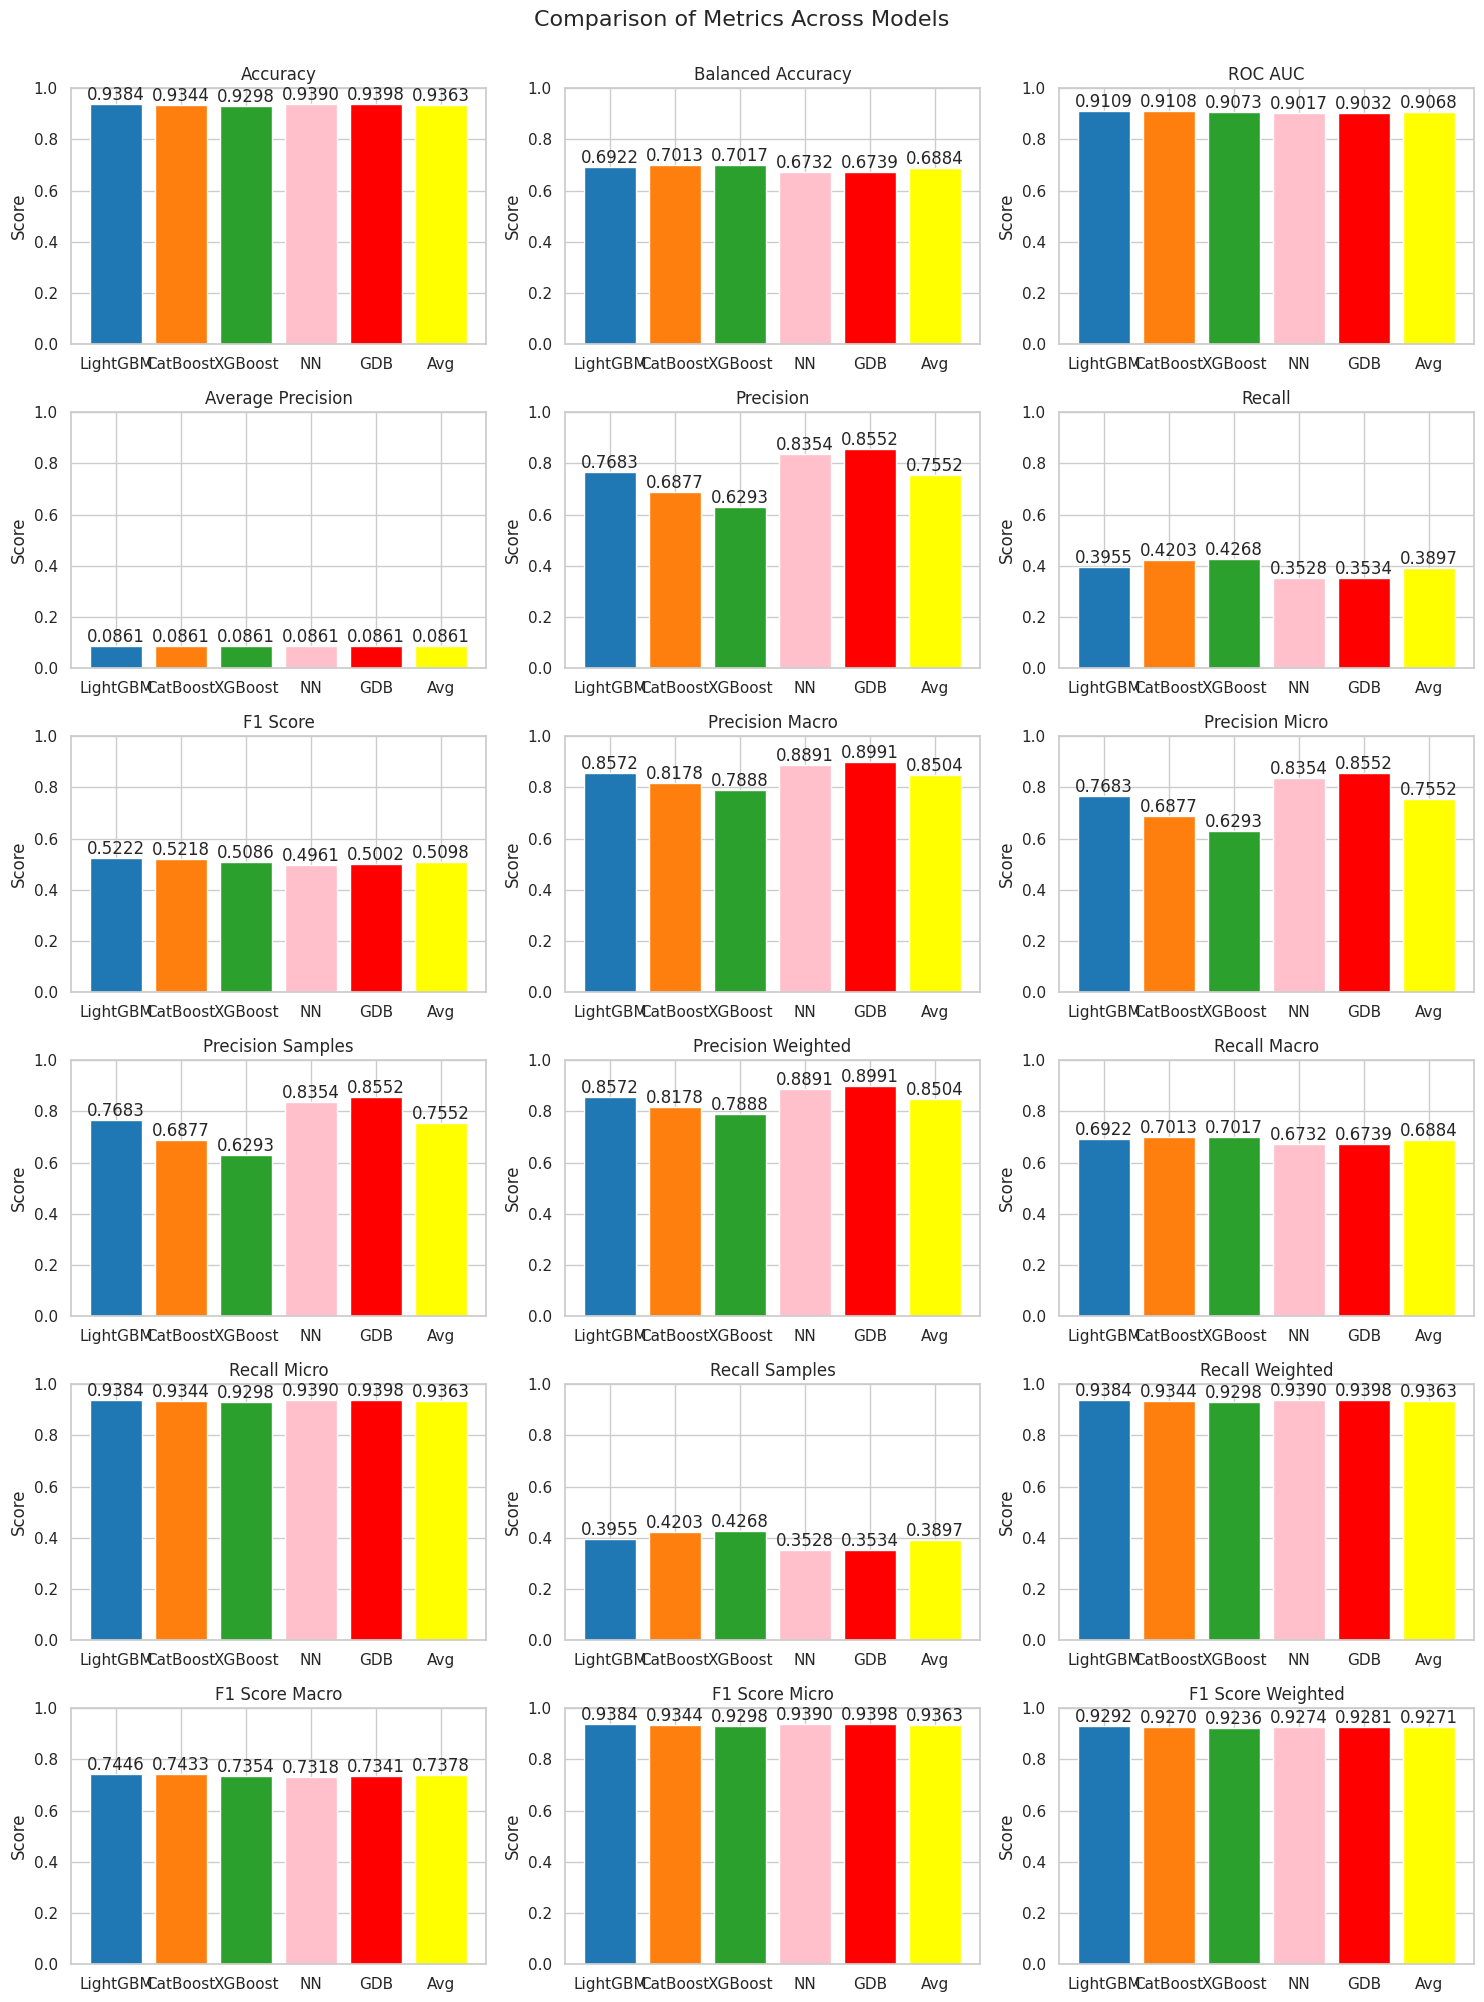

In [418]:
# Calculate the average of the rows
avg_values = (lightgbm_series + catboost_series + xgboost_series + gdb_series) / 5

# Convert the result to a list
avg_values = avg_values.tolist()
# Plotting
fig, axs = plt.subplots(6, 3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5)

for i, metric in enumerate(metrics):
    ax = axs[i // 3, i % 3]
    bars = ax.bar(['LightGBM', 'CatBoost', 'XGBoost','GDB','Avg'], [lightgbm_values[i], catboost_values[i], xgboost_values[i],gdb_values[i],avg_values[i]], color=['#1f77b4', '#ff7f0e', '#2ca02c','pink','red','yellow'])
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    
    # Adding the value on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom')

plt.suptitle('Comparison of Metrics Across Models', fontsize=16, y=1)
plt.tight_layout()
plt.show()

### Further Scope of Improvement 

In this section, an exploration of various base classifiers was undertaken to identify the top 5 classifiers for subsequent analysis. The following combinations will now be examined further:

1. Modelling and Evaluation of optimal ANN architectures on the raw data as well as on generated features data. Determine if ANN should be included among the top-performing models.
2. Assessment of the top N models using Cost Sensitive Classifiers to investigate their performance under different class weighting schemes.
4. Finalization of the top models based on their performance on the test set.

The process of final model optimization will involve the following steps:

1. Tuning hyperparameters of the base classifiers to optimize their performance.
2. Implementing an ensembling framework to leverage the strengths of multiple models for improved predictive accuracy.